In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec


import os
import re

import scipy as sc

################################################
# Load in Factorial Experiment Data
################################################

base_path = "./factorial_experiment/results/"
files = os.listdir(base_path)

file_dfs = []

file_expr = re.compile(r"^Power-(?P<cov>\w+)-(?P<eps>[a-zA-Z0-9]+)_stamp(?P<stamp>[a-zA-Z0-9]+)_t(?P<t>\d+)_B(?P<B>\d+)_n(?P<n>\d+)_p(?P<p>\d+)_target(?P<target>\d+[.]\d+)_seed(?P<seed>\d+)\.csv")
for file in files:
    file_df = pd.read_csv(base_path + file)
    file_data = re.match(file_expr, file).groupdict()
    file_df["cov"] = file_data["cov"]
    file_df["eps"] = file_data["eps"]
    file_df["stamp"] = int(file_data["stamp"])
    file_df["t"] = int(file_data["t"])
    file_df["B"] = int(file_data["B"])
    file_df["n"] = int(file_data["n"])
    file_df["p"] = int(file_data["p"])
    file_df["target"] = float(file_data["target"])
    file_df["seed"] = int(file_data["seed"])
    file_df["experiment_num"] = int(file_data["seed"][-3:])
    file_dfs.append(file_df)

factorial_df = pd.concat(file_dfs, ignore_index = True)
del file_dfs

################################################
# Create the names of the methods
################################################

rename_dict = {
    "OLS__L1" : "OLS-L1",
    "OLS__L2" : "OLS-L2",
    "OLS__Huber": "OLS-Huber",
    "Huber__L1": "Huber-L1",
    "Huber__L2": "Huber-L2",
    "Huber__Huber" : "Huber-Huber",
    "t-test" : "F-test"
}

factorial_df = factorial_df.rename(columns = rename_dict)

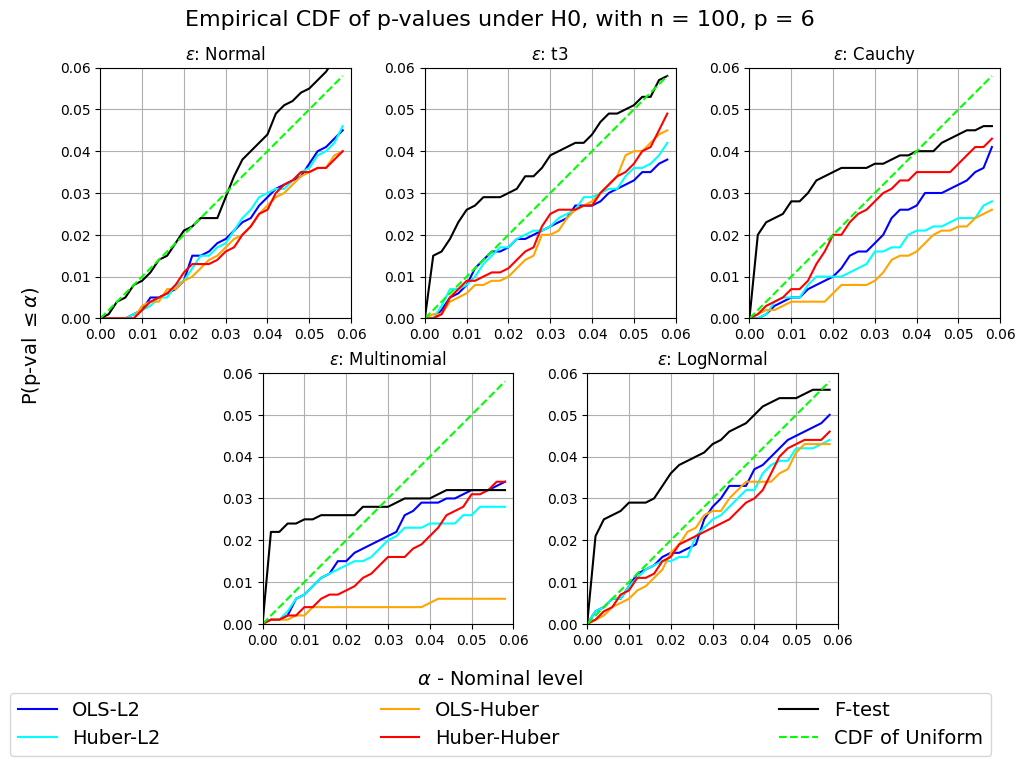

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [2]:
################################################
# Create the colors and names of the methods
################################################

plot_methods = [
    "OLS-L2",
    "Huber-L2",
    "OLS-Huber",
    "Huber-Huber"
]

colors_dict = {
    "OLS-L1" : "palegreen",
    "Huber-L1" : "green",
    "OLS-L2" : "blue",
    "Huber-L2" : "cyan",
    "OLS-Huber" : "orange",
    "Huber-Huber" : "red",
    "F-test" : "black"
}

trials = 1000
covs = ["Cauchy"]
epss = ["Normal", "t3", "Cauchy", "Multinomial", "LogNormal"]
p = 6
targets = [0, 20, 40, 60, 80, 95]

# For sample size simulations
designs = [
    ("Cauchy", "Normal"),
    ("Cauchy", "t3"),
    ("Cauchy", "Cauchy"),
    ("Cauchy", "Multinomial"),
    ("Cauchy", "LogNormal")
]

plotting_designs = [
    ("Cauchy", "Normal"),
    ("Cauchy", "t3"),
    ("Cauchy", "Cauchy"),
    ("Cauchy", "Multinomial"),
    ("Cauchy", "LogNormal")
]


################################################
# Create the full figure parameters
################################################

fig = plt.figure(figsize = (10, 7))
gs = GridSpec(2, 12, figure = fig,
              height_ratios = [1, 1],
              width_ratios = [1] * 12,
              wspace = 10,
              hspace = 0.2
)
plt.subplots_adjust(left = 0.10, right = 1.0, top = 0.9, bottom = 0.1)

ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[0, 4:8])
ax3 = fig.add_subplot(gs[0, 8:12])
ax4 = fig.add_subplot(gs[1, 2:6])
ax5 = fig.add_subplot(gs[1, 6:10])
axs = [ax1, ax2, ax3, ax4, ax5]

################################################
# Create factorial type I error figure
################################################

def plot_factorial_typeI_cell(ax, cov, eps, p):
    cov_mask = factorial_df["cov"] == cov
    eps_mask = factorial_df["eps"] == eps
    p_mask = factorial_df["p"] == p
    target_mask = factorial_df["target"] == 0

    df = factorial_df[cov_mask & eps_mask & p_mask & target_mask][plot_methods + ["F-test"]]

    M = 500
    indices = np.arange(M) / M

    max_alpha = 0.06

    trials_plotting_count = int(M * max_alpha)
    plot_mask = np.arange(trials_plotting_count)

    for col in df:
        empirical_cdf = (df[col].to_numpy().reshape(1, -1) <= indices.reshape(-1, 1)).mean(axis = 1)
        ax.plot(
            indices[plot_mask],
            empirical_cdf[plot_mask],
            label = col,
            color = colors_dict[col]
        )
    ax.plot(indices[plot_mask], indices[plot_mask], "--", color = "lime", label = "CDF of Uniform")

    ax.set_xlim(0.0, max_alpha)
    ax.set_ylim(0.0, max_alpha)
    ax.set_aspect("equal")
    ax.grid(True)

    ax.set_title(f"$\\epsilon$: {eps}")

for j, eps in enumerate(epss):
    plot_factorial_typeI_cell(axs[j], "Cauchy", eps, p)


fig.supxlabel("$\\alpha$ - Nominal level", fontsize = 14)
fig.supylabel("P(p-val $\leq \\alpha$)", fontsize = 14)
fig.suptitle(f"Empirical CDF of p-values under H0, with n = 100, p = {p}", fontsize = 16)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, mode = "expand", ncols = 3, 
    loc = "lower left", bbox_to_anchor = (0., -0.1, 1., 1.), fontsize = 14)

# Show the plot
plt.show()
fig.savefig(f"./images/2-empirical_cdf_sim.eps", dpi = 800, bbox_inches = "tight")
